In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os
sns.set_style('darkgrid')

In [2]:
res_dir = '/home/lmoroni/__workdir/augmenting_nlms_meco/output/probe_2_final'
metric = 'acc_corr' # ['r2', 'corr_acc', 'mse', 'mae']
invert = False

In [3]:
def get_probing_dirs(res_dir):
    return [os.path.join(res_dir, dir_name) for dir_name in os.listdir(res_dir) if dir_name.startswith('probing')]

In [4]:
def get_model_config(src_dir):
    model_config = dict()
    model_str = src_dir.split('/')[-1]
    model_config['language'] = 'it' if '_it_' in model_str else 'en'
    model_config['language_mode'] = 'multi_lingual' if 'xlm' in model_str else 'mono_lingual'
    model_config['pretrained'] = False if 'rand' in model_str else True
    model_str = model_str.split('_')
    model_config['user'] = model_str[2]
    return model_config

In [5]:
def load_result_df(src_dir, model_config, score):
    res_dict = {'user':[], 'language':[], 'language_mode':[], 'pretrained':[], 'layer':[], 'feature':[], 'score':[]}
    src_path = os.path.join(src_dir, 'probe_results.json')
    with open(src_path, 'r') as src_file:
        res_json = json.load(src_file)
        for layer in range(12):
            layer_results = res_json[str(layer)]
            for key, value in layer_results.items():
                if '_test' in key:
                    res_dict['language'].append(model_config['language'])
                    res_dict['language_mode'].append(model_config['language_mode'])
                    res_dict['pretrained'].append(model_config['pretrained'])
                    res_dict['layer'].append(layer)
                    res_dict['feature'].append(key[:-len('_score_test')])
                    res_dict['score'].append(float(value[score]))
                    res_dict['user'].append(model_config['user'])
    df = pd.DataFrame.from_dict(res_dict)                
    return df

In [6]:
src_dirs = get_probing_dirs(res_dir)

In [7]:
def plot_heatmap(ax, all_df, language, language_mode, pretrained, invert):
    filtered_df = all_df[(all_df['language']==language) & (all_df['language_mode'] == language_mode) & (all_df['pretrained'] == pretrained)]
    grouped = filtered_df.groupby(['layer', 'feature'])['score']
    mean_dict = {'layer': [], 'feature':[], 'avg_score': []}
    for group_id, group_df in grouped:
        mean_dict['layer'].append(group_id[0])
        mean_dict['feature'].append(group_id[1])
        mean_dict['avg_score'].append(group_df.mean())
    mean_df = pd.DataFrame.from_dict(mean_dict)
    table = mean_df.pivot(columns='layer', index='feature', values='avg_score')
    if invert:
        table = table.map(lambda x: 100 - x)
    plt.figure(figsize=(8, 5));
    pretrained_str = '' if pretrained else ', random'
    sns.heatmap(ax=ax, data=table, annot=True, fmt=".2f", cmap='GnBu', cbar=False, linewidth=.5).set(title=f'Model = {language}, {language_mode}{pretrained_str}');

In [8]:
all_df = []
for src_dir in src_dirs:
    model_config = get_model_config(src_dir)
    res_df = load_result_df(src_dir, model_config, metric)
    all_df.append(res_df)
all_df = pd.concat(all_df, ignore_index=True)

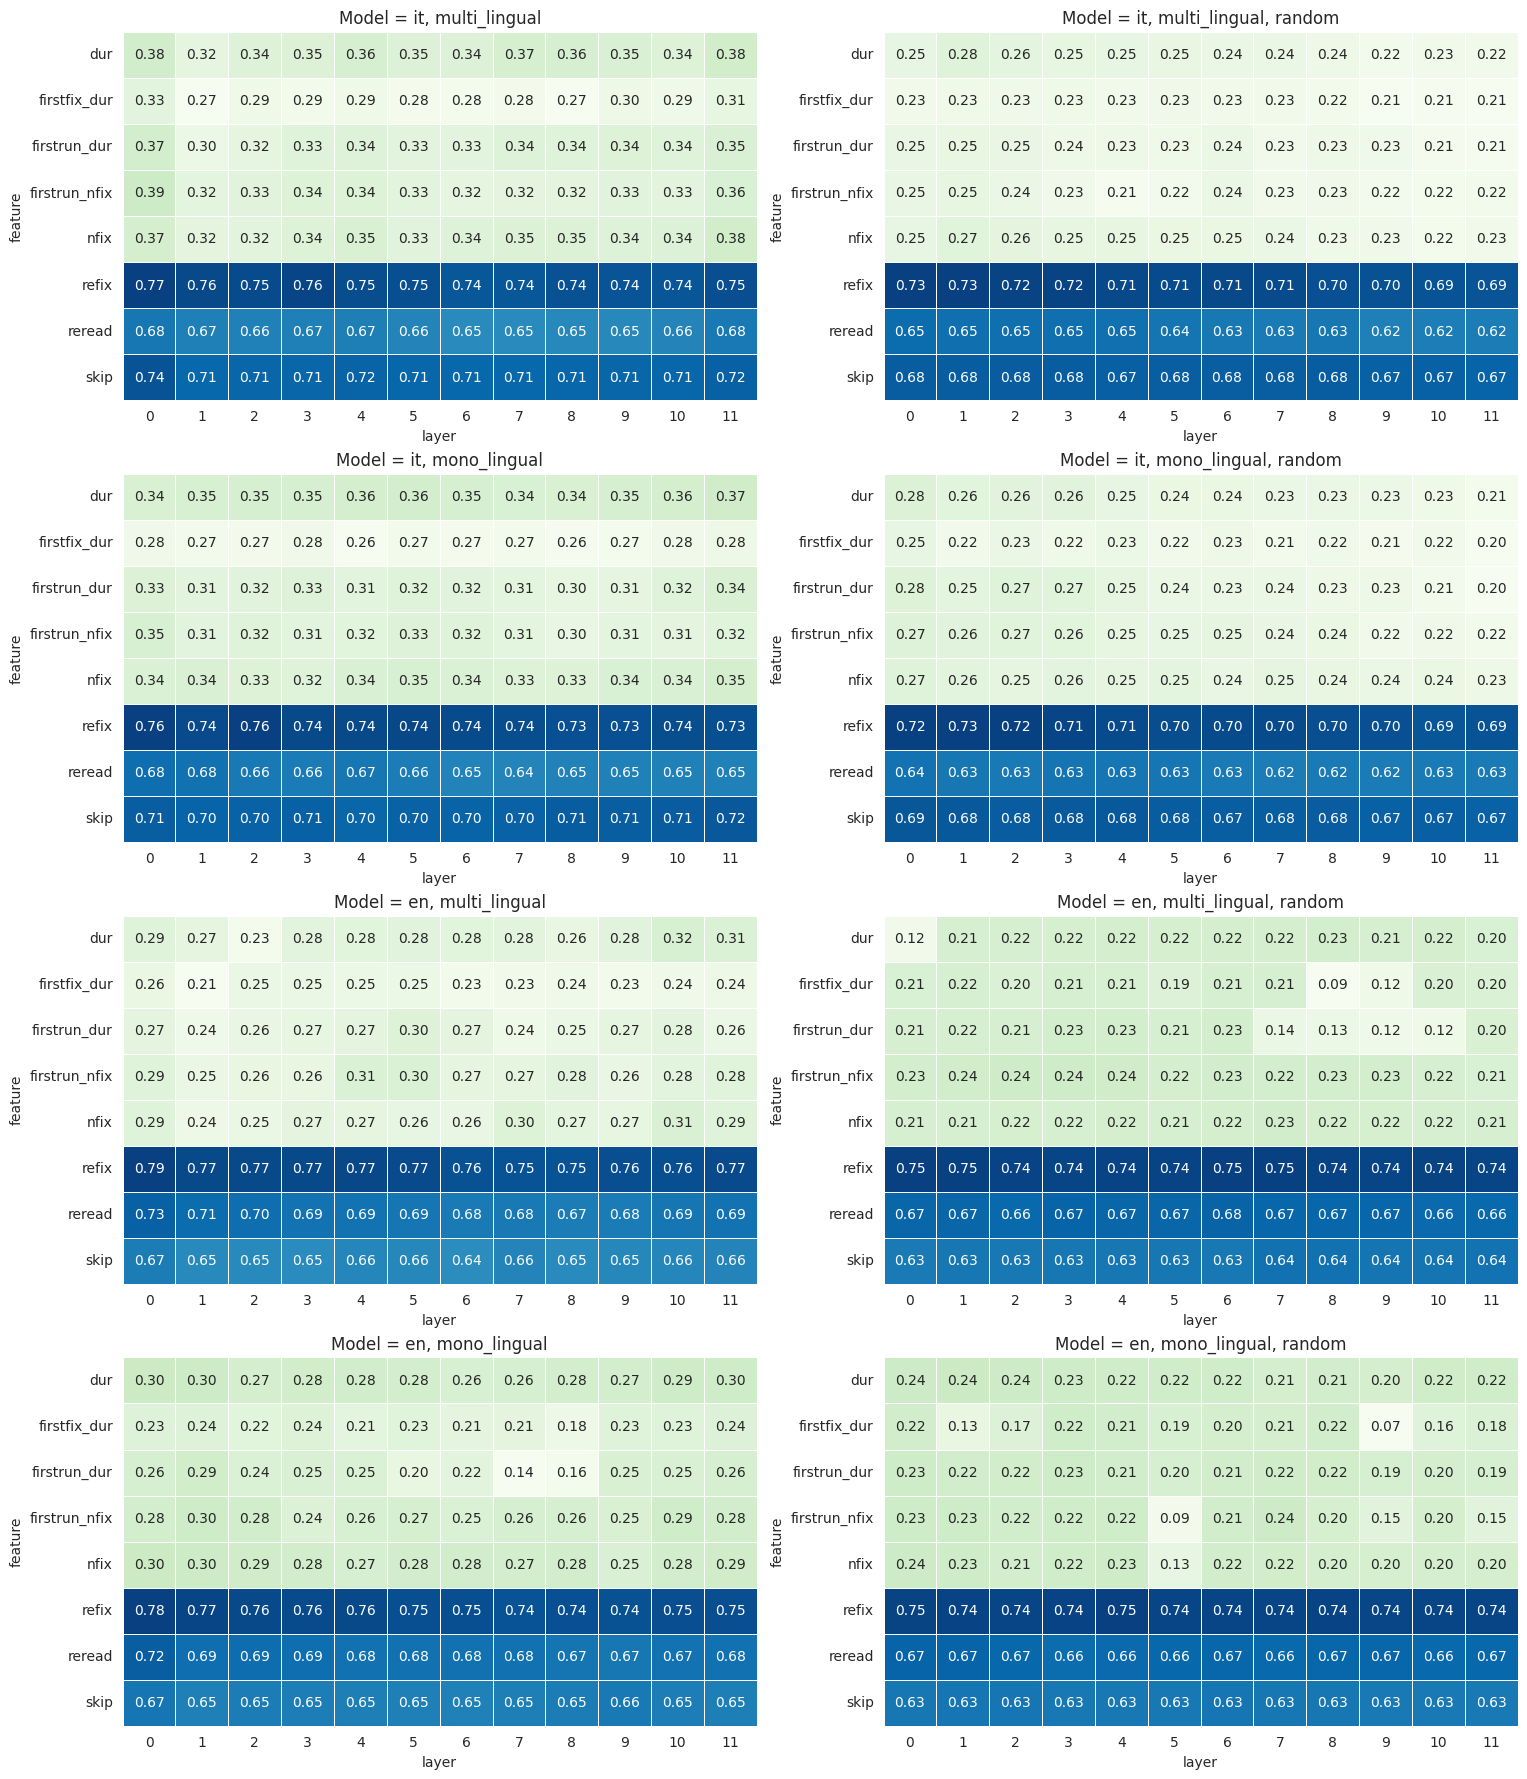

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [9]:
fig, axes = plt.subplots(4, 2, figsize=(18, 22));
axes = axes.flatten();
ax_idx = 0
for language in all_df['language'].unique():
    for language_mode in all_df['language_mode'].unique():
        for pretrained in sorted(all_df['pretrained'].unique(), reverse=True):
            plot_heatmap(axes[ax_idx], all_df, language, language_mode, pretrained, invert)
            ax_idx += 1
            
fig.savefig('/home/luca/Workspace/augmenting_nlms_meco/output/plots/probing_all.png')

In [10]:
# for language in all_df['language'].unique():
#     for language_mode in all_df['language_mode'].unique():
#         for pretrained in all_df['pretrained'].unique():
#             plot_heatmap(all_df, language, language_mode, pretrained)
#             plt.show()
#             plt.clf();